# Imports

In [2]:
import numpy as np
import torch
from torch import nn
import pygad
import pygad.torchga as torchga
import gym
import random
import matplotlib.pyplot as plt

# Enviroment


In [3]:
env_si = gym.make("SpaceInvaders-v4")
env_si.reset()
print("Número de ações:")
print(env_si.action_space)
print("Significado das ações:")
print(env_si.get_action_meanings())

Número de ações:
Discrete(6)
Significado das ações:
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


# Buffer para evitar de estourar a RAM

In [4]:
class ReplayBuffer():

    def __init__(self, capacity = 1000):
        
        self.buffer = np.empty((capacity, 2, 3, 210, 160))
        self.pointer = 0

    def add(self, state, state_next):

        self.pointer = (self.pointer + 1) % self.buffer.shape[0]
        self.buffer[self.pointer][0] = state
        self.buffer[self.pointer][1] = state_next
    
    def sample(self, n=32):

        idx = np.random.randint(0, self.buffer.shape[0], n)
        return np.split(self.buffer[idx,:], 2, axis=1)

state = env_si.render(mode="rgb_array").transpose((2,0,1)) /255
buffer = ReplayBuffer()

for i in range(1000):

    action = random.randint(0,5)
    next_state, reward, done, _ = env_si.step(action)
    next_state = next_state.transpose((2,0,1)) / 255
    buffer.add(state, next_state)
    state = next_state

    if done:
        env_si.reset()
        env_si.seed()

env_si.reset()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)

# AutoEncoder

In [3]:
class AutoEncoder(nn.Module):

    def __init__(self) -> None:
        super(AutoEncoder, self).__init__()

        self.conv_encoder = nn.Sequential(nn.Conv2d(3, 32, 7, padding=3),
                        nn.ReLU(True),
                        nn.MaxPool2d(4, 4),
                        nn.Conv2d(32, 64, 5, padding=2),
                        nn.ReLU(True),
                        nn.MaxPool2d(4, 4))

        self.linear_encoder = nn.Sequential(nn.Flatten(),
                        nn.Linear(8320, 50),
                        nn.ReLU(True))

        self.linear_decoder = nn.Sequential(nn.Linear(50, 8320),
                        nn.ReLU(True),
                        nn.Unflatten(1, (64,13,10)))

        self.conv_decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, 4, stride=4),
                        nn.ReLU(True),
                        nn.ConvTranspose2d(32, 3, 4, stride=4, output_padding=(2,0)),
                        nn.Sigmoid())

    def forward(self, x, mode=0):

        y = self.conv_encoder(x)
        y = self.linear_encoder(y)
        if mode==1: 
          return y
        y = self.linear_decoder(y)
        y = self.conv_decoder(y)
        return y

conv_ae = AutoEncoder()
print(conv_ae)

AutoEncoder(
  (conv_encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8320, out_features=50, bias=True)
    (2): ReLU(inplace=True)
  )
  (linear_decoder): Sequential(
    (0): Linear(in_features=50, out_features=8320, bias=True)
    (1): ReLU(inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(64, 13, 10))
  )
  (conv_decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(4, 4), output_padding=(2, 0))
    (3): Sigm

# Loss e Optimizer

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(conv_ae.parameters(), 0.005)

# Treinamento

In [7]:
loss_array = np.array([])
n_episodes = 20

for episode in range(n_episodes):

    done = False
    env_si.reset()
    env_si.seed()

    state = (env_si.render("rgb_array") / 255).transpose((2,0,1))
    n_step = 0

    while not done:

        action = random.randint(0,5)
        next_state, reward, done, _ = env_si.step(action)
        next_state = (next_state / 255).transpose((2,0,1))
        buffer.add(state, next_state)
        state = next_state

        Xs, Ys = buffer.sample()
        Xs = torch.tensor(Xs.astype(np.float32).reshape(32,3,210,160))
        Ys = torch.tensor(Ys.astype(np.float32).reshape(32,3,210,160))

        output = conv_ae.forward(Xs)
        optimizer.zero_grad()
        loss = criterion(output, Ys)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.detach().numpy())
        print(f"Episode: {episode+1}. Step: {n_step}. Loss: {loss}")
        n_step += 1

Episode: 1. Step: 0. Loss: 0.2188345342874527
Episode: 1. Step: 1. Loss: 0.21906645596027374
Episode: 1. Step: 2. Loss: 0.21878258883953094
Episode: 1. Step: 3. Loss: 0.21850994229316711
Episode: 1. Step: 4. Loss: 0.21855980157852173
Episode: 1. Step: 5. Loss: 0.21873411536216736
Episode: 1. Step: 6. Loss: 0.2187427580356598
Episode: 1. Step: 7. Loss: 0.21791040897369385
Episode: 1. Step: 8. Loss: 0.21811357140541077
Episode: 1. Step: 9. Loss: 0.21866440773010254
Episode: 1. Step: 10. Loss: 0.21801607310771942
Episode: 1. Step: 11. Loss: 0.21788504719734192
Episode: 1. Step: 12. Loss: 0.21797692775726318
Episode: 1. Step: 13. Loss: 0.21783539652824402
Episode: 1. Step: 14. Loss: 0.21765360236167908
Episode: 1. Step: 15. Loss: 0.21767698228359222
Episode: 1. Step: 16. Loss: 0.21760308742523193
Episode: 1. Step: 17. Loss: 0.21681182086467743
Episode: 1. Step: 18. Loss: 0.216998890042305
Episode: 1. Step: 19. Loss: 0.21726353466510773
Episode: 1. Step: 20. Loss: 0.21711760759353638
Episod

# Salvar progreso

In [8]:
torch.save(conv_ae.state_dict(), "conv_ae")
np.save("loss_conv_ae", loss_array)

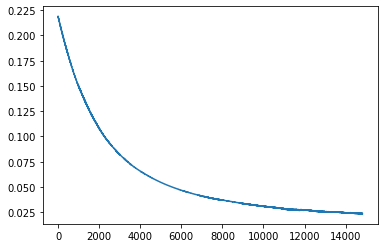

In [4]:
loss_array = np.load("loss_conv_ae.npy")
plt.plot(loss_array)